# Introduction

In this tutorial, we'll be walking through the Keras code behind creating a convolutional neural network. Understanding the code and concepts will require familiarity in creating neural networks. If you want to review or learn about that, the notes from last week's workshop are [here](https://github.com/uclaacmai/tf-workshop-series/tree/master/week6-neural-nets).


In [3]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import numpy as np
np.random.seed(1000)

Using TensorFlow backend.


Let's make a simple API call to get our dataset. Today, we'll be working with CIFAR 10 - a slightly more interesting dataset than MNIST, in that we have 3 channels instead of a single channel, and much more training data. Our images and dataset size are still comparatively small, however, making this a good dataset to use for demonstration purposes.

Specifically, the code below will return 2 tuples:`(x_train, x_test)`: array of RGB image data with shape (num_samples, 32, 32, 3). and `(y_train, y_test)`: array of category labels (integers in range 0-9) with shape (num_samples, 1).

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # may take a while to download


In [6]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [7]:
print(x_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000, 1)


We need to one-hot encode our labels, so that we can run softmax on our output, which will be of shape $1 * 10$.

In [8]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

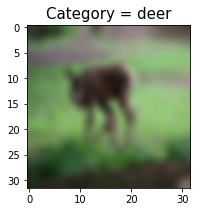

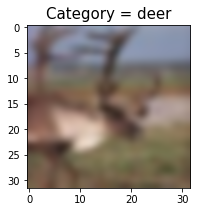

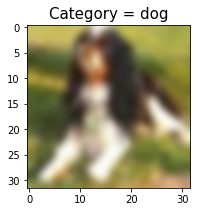

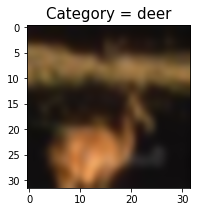

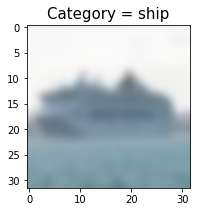

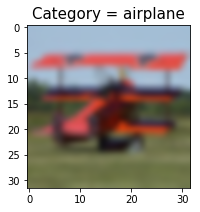

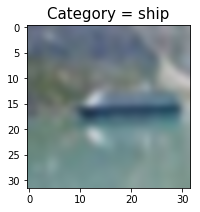

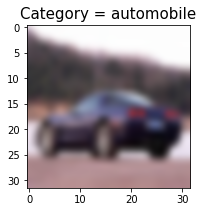

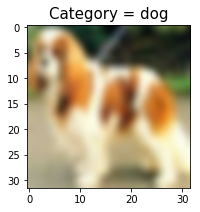

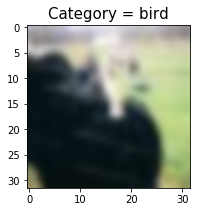

In [9]:
import re
import matplotlib.pyplot as plt
%matplotlib inline
# pass in a list of tuples(image, label)
def plot_CIFAR(images_and_labels, predictions=None):
    label_dict = {0: 'airplane', 1:'automobile', 2:'bird',
                  3: 'cat', 4:'deer', 5: 'dog', 6:'frog',
                  7:'horse', 8:'ship', 9: 'truck'}
    for i in range(len(images_and_labels)):
        image_data, image_label = images_and_labels[i]
        img = image_data
        title = label_dict[image_label]
        if predictions:
            pred_label = predictions[i]
            title += ' Prediction: {}'.format(label_dict[pred_label])
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot(111)
        ax.imshow(img,interpolation='bicubic')
        ax.set_title('Category = '+ title,fontsize =15)
        plt.show()

def get_random_images():
    indices = np.random.randint(0, x_train.shape[0]-1, 10)
    images_and_labels = []
    for idx in indices:
        image, label = x_train[idx], y_train[idx]
        label = [i for i,val in enumerate(label) if val == 1][0] #un OHE
        images_and_labels.append((image, label))
    return images_and_labels

# to be used later
def get_first_10():
  images_and_labels = []
  for i in range(10):
    image, label = x_test[i], y_test[i]
    label = [i for i,val in enumerate(label) if val == 1][0] #un OHE
    images_and_labels.append((image, label))
  return images_and_labels
    

images_and_labels = get_random_images()
plot_CIFAR(images_and_labels)
# image, label = x_train[0], y_train[0]
# label = [i for i, val in enumerate(label) if val == 1][0]
# images_and_labels = [(image, label)]
# print(label)
# plot_CIFAR(images_and_labels)

### Aside: Batch Normalization

Training very deep neural networks is hard. It turns out one significant issue with deep neural networks is that the activations of each layer tend to converge to 0 in the later layers, and therefore the gradients vanish as they backpropagate throughout the network.

A lot of this has to do with the sheer size of the network - obviously as you multiply numbers less than zero together over and over, they’ll converge to zero, and that’s partially why network architectures such as InceptionV3 insert auxiliary classifiers after layers earlier on in their network, so there’s a stronger gradient signal back propagated during the first few epochs of training.

However, there’s also a more subtle issue that leads to this problem of vanishing activations and gradients. It has to do with the initialization of the weights in each layer of our network, and the subsequent distributions of the activations in our network. Understanding this issue is key to understanding why batch normalization is now a staple in training deep networks.

![example](https://raw.githubusercontent.com/uclaacmai/advanced-track-fall18/master/cnn-workshop/activation_0.png)
![example2](https://raw.githubusercontent.com/uclaacmai/advanced-track-fall18/master/cnn-workshop/activation_19.png)

What’s important to notice is that in later layers, *nearly all of the activations are zero* (just look at the scale of the axes). If we look at the distributions of these activations, it’s clear that they differ significantly with respect to each other - the first activation takes on a clear Gaussian shape around 0, while successive hidden layers have most of their activations at 0, with rapidly decreasing variance. This is what the [batch normalization paper](https://arxiv.org/pdf/1502.03167.pdf) refers to as *internal covariate shift* - it basically means that the distributions of activations differ with respect to each other.

**Why does this matter, and why is this bad?**

This is bad mostly due to the small, and decreasing variance in the distributions of our activations across layers. Having zero activations is fine, unless nearly all your activations are zero. To understand why this is bad, we need to look at the backwards pass of our network, which is responsible for computing each gradient dLdwidLdwi across each hidden layer in our network. Given the following formulation of an arbitrary layer in our network: $$h_i=relu(W_ih_i−1+b_i)$$ where $$h_i$$ denotes the activations of the *i*th layer in our network, we can construct the local gradient $$\frac{dL}{dW_i}$$. Given an upstream gradient into this layer $$\frac{dL}{dh_i}$$, we can compute the local gradient with the chain rule:

$$\frac{dL}{dW_i} = \frac{dL}{dh_i} * \frac{dh_i}{dw_i}$$

Applying the derivatives, we obtain:

$$\frac{dL}{dw_i} = \frac{dL}{dh_i}( \mathbb{1}(W_ih_{i-1} + b > 0))h_{i-1}$$

**What does this tell us about our gradients for our weights?**

The expression for the gradient of our weights is intuitive: for every element in the incoming gradient matrix, pass the gradient through if this layer’s linear transformation would activate the relu neuron at that element, and scale the gradient by our input into this layer. Otherwise, zero out the gradient.

This means that if the incoming gradient at a certain element wasn’t already zero, it will be scaled by the input into this layer. The input in this layer is just the activations from the previous layer in our network. And as we discussed above, essentially all of those activations were zero.

Therefore, nearly all of the gradients backpropagated through our network will be zero, and few weight updates, if any, will occur. In the final few layers of our network, this isn’t as much of a problem, since the number of times a gradient has had the opportunity to be “scaled” by a zero activation is small, but after we backpropagate even a few layers, chances are high that the gradient is already zero.

![hihi](https://raw.githubusercontent.com/uclaacmai/advanced-track-fall18/master/cnn-workshop/grads_layer_20.png)
![pls](https://raw.githubusercontent.com/uclaacmai/advanced-track-fall18/master/cnn-workshop/grad_layer2.png)

Batch normalization is a way to fix the root cause of our issue of zero activations and vanishing gradients: reducing internal covariate shift. We want to ensure that the variances of our activations do not differ too much from each other. Batch normalization does this by normalizing each activation in a batch:



$$x_k = \frac{x_k - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$$

Here, we denote$$ x_k$$ to be a certain activation, and $$\mu_B$$, $$\sigma^2_B$$ to be the mean and variance across the minibatch for that activation. A small constant $$\epsilon$$ is added to ensure that we don't divide by zero. 

This constrains all hidden layer activations to have zero mean and unit variance, so the variances in our hidden layer activations should not differ too much from each other, and therefore we shouldn’t have nearly all our activations be zero.

It’s important to note here that batch normalization doesn’t *force* the network activations to rigidly follow this distribution at all times, because the above result is scaled and shifted by some parameters before being passed as input into the next layer:

$$y_k = \gamma \hat{x_i} + \beta$$

### Defining the AlexNet Model

AlexNet was a major breakthrough in deep learning in 2012, which revived the interest in neural network based models. It's comparatively simple compared to the convolutional neural networks used today, but obtains high accuracy on image classification problems. The full paper is [here](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). Today, we'll implement a version of the AlexNet model that aims to replicate the model described in the paper.


In [10]:
def alexnet_model(img_shape=(32,32,3), n_classes=10, l2_reg=0., weights=None):
    alexnet = Sequential()
    # layer 1
    # note: 11x11 changed to 7x7
    alexnet.add(Conv2D(96, (7, 7), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2,2))) # implicit stride of 1 creates overlapping pooling
    
    # layer 2
    # TODO: implement layer 2, which has a 5x5 convolution with 256 filters, and uses same padding.
    # We should apply Batch Normalization before the Relu
    # also, we should do a 2x2 overlapping max pool at the end
    
    # layer 3
    alexnet.add(ZeroPadding2D((1, 1)))
    # TODO: implement layer 3, which has a 3x3 conv, 512 filters, and uses same padding. 
    # the batchnorm, activation, and pooling should be the same as in layer 2.
    alexnet.add(Conv2D(512, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))
    
    # layer 4
    # TODO: implement layer 4 to be the same as layer 3, except we should have 1024 filters and no max pool at the end.
    
    # layer 5
    # TODO: implement layer 5 to be the same as layer 3, except we should have 1024 filters.
    
    # layer 6
    # TODO: implement layer 6, which is the first FC layer.  It should have 3072 neurons.
    # We should have batch norm before the nonlinearity, and dropout with p=0.5
    
    # layer 7
    # TODO: implement layer 7, which is the 2nd FC layer. It should have 4096 neurons.
    # The Batchnorm and dropout should be the same as in layer 6.
    
    # Layer 8
    # TODO: implement layer 8, which is the softmax layer. It should have batchnorm before applying the softmax operation.
    
    if weights:
        alexnet.load_weights(weights)
    return alexnet 


In [11]:
model = alexnet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        14208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 512)       442880    
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 512)       2048      
__________

In [0]:
model = alexnet_model()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [13]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test),
          )
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 14s 1ms/step
Test loss: 1.3811476108551026
Test accuracy: 0.5224


(20,)
[3, 1, 3, 2, 4, 4, 1, 2, 3, 1, 4, 9, 4, 7, 9, 2, 5, 7, 8, 4]


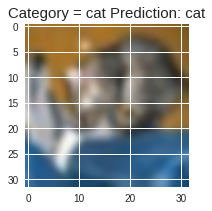

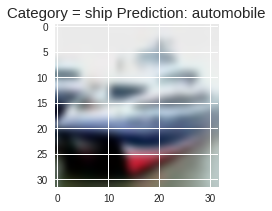

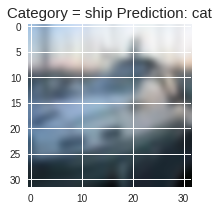

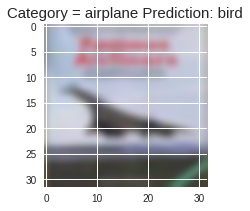

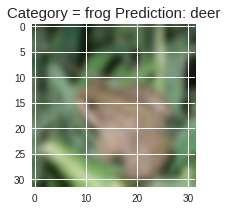

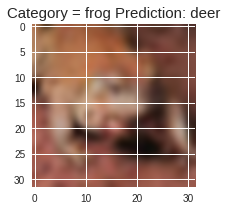

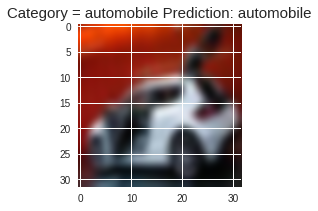

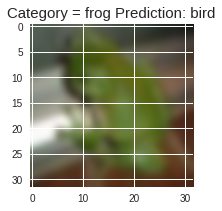

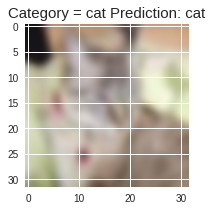

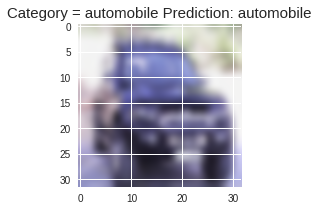

In [29]:
predictions = model.predict(x_test[:20])
preds = np.argmax(predictions,axis=1)
print(preds.shape)
images_and_labels = get_first_10()
preds = list(preds)
print(preds)
plot_CIFAR(images_and_labels, preds)